Código disponível [na minha página do Github](https://github.com/arthurkenzo/atividades_ia525)

## Questão 1:

O programa linear que resolve o problema de fluxo mínimo é dado por:

\begin{align*}
    \text{Minimizar }    & f  \\
    \text{ sujeito a }  & \sum_{(i, j)\in E} x_{ij} = \sum_{(k, i)\in E} x_{ki} \quad \forall i \in V, \: i \neq 1, m \hspace{20pt \text{(Conservação de fluxo)}} \\
                        & \sum_{(i, j)\in E} x_{ij} - \sum_{(k, i)\in E} x_{ki} = f, \quad i = 1 \hspace{20pt \text{(Fluxo de entrada no nó 1)}} \\
                        & \sum_{(i, j)\in E} x_{ij} - \sum_{(k, i)\in E} x_{ki} = -f, \quad i = m \hspace{20pt \text{(Fluxo de saída no nó m)}} \\
                        & 0 \leq l_{ij} \leq x_{ij} \leq u_{ij} \quad \forall (i,j) \in E  \hspace{20pt \text{(Limites de fluxo inferior e superior)}} \\
                        & 
\end{align*}

onde a rede é dada por um grafo direcionado $G(V,E)$, $f$ é o fluxo de entrada/saída, $x_{ij}$ são variáveis quantificando o fluxo em cada arco da rede, e $l_{ij}$ e $u_{ij}$ são respectivamente os limites inferior e superior de fluxo em cada nó.

Podemos enxergar esse problema em um problema de fluxo _de custo mínimo_. Para isso, precisamos modificar ligeiramente a rede do problema, adicionando um arco auxiliar entre os nós de entrada e saída, de forma que todo o fluxo da rede passe por ele. Agora, mantendo as capacidades dos arcos como estão, podemos atribuir um custo $c_{ij}$ nulo a todos os arcos da rede, exceto o arco de retorno, que terá custo $c_{mi} = 1$. Dessa forma, o solver irá procurar por soluções que minimizem o fluxo passando pelo arco de retorno, visto que é o único com custo positivo.  

## Questão 2:

O processo para se resolver o problema de fluxo mínimo por meio de problemas de fluxo máximo começa pela simples resolução do problema de fluxo máximo na rede original. Como as restrições dos dois problemas são iguais, toda solução factível de fluxo máximo é também factível para o fluxo mínimo. 

Precisamos agora modificar a rede em função dos resultados obtidos no passo anterior. Dados os fluxos máximos na rede original $x_{ij}^*$, aplicamos sobre ela as seguintes transformações:

\begin{align*}
    e_{ij} & \rightarrow e_{ji} \\
    u_{ij} & \rightarrow x_{ij}^* - l_{ij} := v_{ij}\\
    f & \rightarrow -f
\end{align*}

Essas transformações criam um novo problema de maximização de fluxo, com arcos em direções opostas aos da rede original, capacidade máxima igual à diferença entre o fluxo máximo do primeiro problema e a capacidade mínima, e fluxos de entrada e saída invertidos. Note que, como queremos resolver um problema de fluxo máximo padrão, não consideramos aqui capacidades mínimas para os arcos. 

Com isso, a maximização desse novo problema nos dará a maior quantidade de fluxo possível de ser retirada da rede original, sem desrespeitar as suas restrições - chamaremos os valores ótimos dessa nova solução de $y_{ij}^*$. O resultado final do algotimo é então dado pela diferença das duas soluções encontradas (consideramos que as soluções do segundo problema, que representam fluxos em direções opostas ao original, carregam um sinal negativo):

$$ x_{ij}^{\text{min}} = x_{ij}^* - y_{ij}^*$$

Note que o resultado obtido ainda representa uma solução factível para a rede do problema original: 

$$ y_{ij}^* \leq v_{ij} = x_{ij}^* - l_{ij} \leq u_{ij} - l_{ij}  \quad\implies \quad l_{ij} \leq x_{ij}^* - y_{ij}^* = x_{ij}^{\text{min}} \leq u_{ij}$$

Resta ainda mostrar que $x_{ij}^{\text{min}}$ representa efetivamente a solução de fluxo mínimo. Podemos argumentar que, retirando a maior quantidade de fluxo possível das arestas  a partir de uma solução factível, a solução final obtida é a de fluxo mínimo, já que qualquer redução adicional dos fluxos levaria a quebra de alguma das restrições. No entanto, seria interessante argumentar de forma mais analítica esse fato... 






## Questão 3:

Sabemos que toda solução factível respeita as desigualdades:

$$ l_{ij} \leq x_{ij} \leq u_{ij} \quad \forall (i,j)\in E \quad \implies \quad  -x_{ij} \geq -u_{ij} \quad \forall (i,j)\in E$$

$$ \sum_{(i,j)\in(X,\bar{X})}l_{ij} \leq \sum_{(i,j)\in(X,\bar{X})}x_{ij} \leq \sum_{(i,j)\in(\bar{X}\ X)}u_{ij} $$

Analisando a expressão para o fluxo líquido, chegamos então no resultado:

\begin{align*}
\phi(X, \bar{X}) = & \sum_{(i,j)\in(X,\bar{X})}x_{ij} -\sum_{(i,j)\in(\bar{X}, X)}x_{ij} \\
\:\geq & \sum_{(i,j)\in(X,\bar{X})}l_{ij} -\sum_{(i,j)\in(\bar{X}, X)}x_{ij} \\
\:\geq & \sum_{(i,j)\in(X,\bar{X})}l_{ij} -\sum_{(i,j)\in(\bar{X}, X)}u_{ij} = L(X, \bar{X})
\end{align*}

Concluímos então que o fluxo líquido em um corte da rede gera um limitante superior para a capacidade líquida desse mesmo corte. Podemos assim conjecturar a existência de um teorema de _min-flow/max-net-cut_: o valor do menor fluxo na rede pode ser dado pelo maior valor de capcaidade líquida dentre todos os cortes do grafo. 

## Questão 4:
Implementação do algoritmo de fluxo mínimo em duas etapas de fluxo máximo:

In [58]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt
import time
import networkx as nx

from typing import Tuple

### Montando grafo simples para verificação do algoritmo

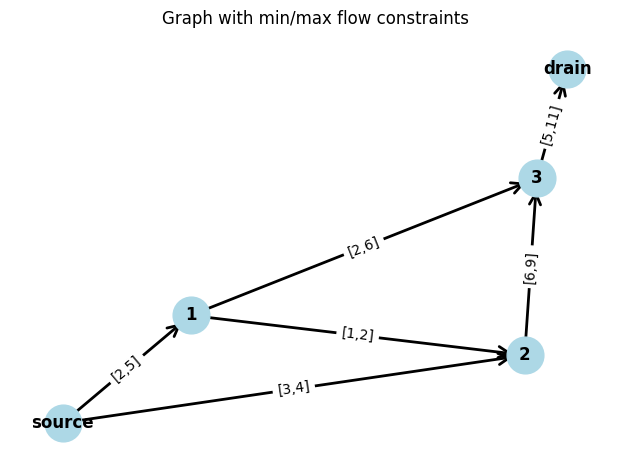

In [59]:
# Create directed graph
G = nx.DiGraph()

# Add nodes (optional, NetworkX creates nodes when edges are added)
G.add_nodes_from(['source', '1', '2', '3', 'drain'])

# Add edges with custom attributes: 'min' and 'max' for flow bounds
G.add_edge('source', '1', lowerBound=2, upperBound=5)
G.add_edge('source', '2', lowerBound=3, upperBound=4)
G.add_edge('1', '2', lowerBound=1, upperBound=2)
G.add_edge('1', '3', lowerBound=2, upperBound=6)
G.add_edge('2', '3', lowerBound=6, upperBound=9)
G.add_edge('3', 'drain', lowerBound=5, upperBound=11)

# Define layout for positioning nodes
pos = nx.spring_layout(G, seed=1)  # or nx.planar_layout(G), nx.shell_layout(G), etc.

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Prepare edge labels with min/max flow
edge_labels = {(u, v): f"[{d['lowerBound']},{d['upperBound']}]" for u, v, d in G.edges(data=True)}

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Display plot
plt.title("Graph with min/max flow constraints")
plt.axis('off')
plt.tight_layout()
plt.show()

### Implementando o algoritmo para resolução do problema de fluxo máximo

In [60]:
def SolveMaxFlow(G:nx.Graph, flowSign:int = 1) -> Tuple[dict[str, np.ndarray], float]:
    """ 
        Builds and solves the max flow problem on a graph G with upper bounds on the edge capacities.
        Assumes the graph edges have a attribute named 'upperBound'. The first node is considered the source and 
        the last the sink, which is inverted when flowSign = -1. 

    Args:
        G (nx.Graph): Directed graph with upper bounds on edge capacity.\n
        flowSign (int, optional): If 1, first node is the source and last one the sink. If -1, this is inverted. Defaults to 1.

    Returns:
        Tuple[dict[str, np.ndarray], float]: Returns a dictionary with variable names as keys and optimal values as values, 
            together with the optimum objective value. 
    """

    # getting list of edges, nodes and defining the source and drain nodes
    edges = list(G.edges)
    nodes = list(G.nodes)
    source, drain = 'source', 'drain'

    # defining decision variables:
    flows = [cp.Variable(integer=True, name=f'flow_{i}_{j}') for i, j  in edges]
    totalFlow = cp.Variable(name='f')

    # defining constraints:
    # upper and lower limits for each flow
    upperBounds = [G.edges[edge]['upperBound'] for edge in edges]
    constraints = [flow >= 0 for flow in flows] 
    constraints.extend( [flow <= ub for flow, ub in zip(flows, upperBounds)] ) 

    # flow conservation constraints
    for node in nodes:
        inflow = cp.sum([flow for (i, j), flow in zip(edges, flows) if i == node])
        outflow = cp.sum([-flow for (i, j), flow in zip(edges, flows) if j == node])

        if node not in [source, drain]:
            constraints.append(inflow + outflow == 0)
        elif node == source:
            constraints.append(inflow + outflow == totalFlow*flowSign)
        elif node == drain:
            constraints.append(inflow + outflow == -totalFlow*flowSign)

    # building the objective and LP
    objective = cp.Maximize( totalFlow )
    lp = cp.Problem(objective, constraints)

    # solving an returning the solution, if an optimum is found
    lp.solve(verbose=False)

    if lp.status == cp.OPTIMAL:
        optimalSolution = {var.name(): var.value.round(5) for var in lp.variables()}
        return optimalSolution, round(lp.value, 5)
    else:
        return None, None

### Resolvendo fluxo mínimo utilizando fluxo máximo:

In [71]:
def SolveMinFlow(G:nx.Graph, printIntermediateResuls:bool=False) -> np.ndarray:
    """ Solves the min flow problem on a graph using a max flow problem solver.
        Assumes the graph edges have attributes named 'upperBound' and 'lowerBound'.
        The first node is considered the source and the last the sink. 

    Args:
        G (nx.Graph): Directed graph with upper and lower bounds on edge capacity.\n
        printIntermediateResuls (bool, optional): prints solutions to the intermediate max flow problems. Defaults to False.

    Returns:
        np.ndarray: Optimal variable values for the min flow problem.
    """

    # solving a max flow problem on the original graph
    optimalSolutionOriginal, optimumOriginal = SolveMaxFlow(G, flowSign=1)

    if printIntermediateResuls:
        print("Max flow solution on original graph:")
        print("Solution:\n", optimalSolutionOriginal)
        print("Optimum value:\n", optimumOriginal)
        print("")

    # invert the direction of all edges
    G_modified = G.reverse(copy=True)

    # apply the transformation for the upper edge capacity
    for u, v, attributes in G.edges(data=True):

        originalMaxFlow = optimalSolutionOriginal.get(f'flow_{u}_{v}')
        G_modified.edges[v, u]['upperBound'] = originalMaxFlow - attributes['lowerBound']

    # solving a max flow problem on the transformed graph
    optimalSolutionInverted, optimumInverted = SolveMaxFlow(G_modified, flowSign=-1)

    if printIntermediateResuls:
        print("Max flow solution on transformed graph:")
        print("Solution:\n", optimalSolutionInverted)
        print("Optimum value:\n", optimumInverted)
        print("")

    # building min flow solution from the two previous results
    minFlowSolution = np.array(list(optimalSolutionOriginal.values())) - np.array(list(optimalSolutionInverted.values()))

    return minFlowSolution


print(SolveMinFlow(G, True))

Max flow solution on original graph:
Solution:
 {'f': np.float64(2.0), 'flow_source_1s': np.float64(1.0), 'flow_source_2s': np.float64(1.0), 'flow_1s_1d': np.float64(1.0), 'flow_1d_drain': np.float64(1.0), 'flow_1d_2s': np.float64(0.0), 'flow_2s_2d': np.float64(1.0), 'flow_2d_drain': np.float64(1.0)}
Optimum value:
 2.0

Max flow solution on transformed graph:
Solution:
 {'f': np.float64(0.0), 'flow_drain_1d': np.float64(0.0), 'flow_drain_2d': np.float64(0.0), 'flow_1s_source': np.float64(0.0), 'flow_1d_1s': np.float64(0.0), 'flow_2s_source': np.float64(0.0), 'flow_2s_1d': np.float64(0.0), 'flow_2d_2s': np.float64(0.0)}
Optimum value:
 0.0

[2. 1. 1. 1. 1. 0. 1. 1.]


Note que, para o grafo utilizado como exemplo, o corte com maior capacidade líquida é o definido por 

$$ \{X, \bar{X}\} = \{ (0, 1, 2), (3, 4) \}, \ \text{onde}\;  L(X, \bar{X}) = 8 $$

que foi exatamente o valor obtido pelo algoritmo implementado acima. 

É importante ressaltar que as variáveis de decisão nas modelagens do problema de fluxo máximo precisaram ser restritas a valores inteiros. Quando essa restrição não é utilizada, o solver retorna soluções não inteiras no primeiro problema, gerando infactibilidades no segundo problema após a transformação do grafo (capacidades máximas negativas). Concluímos então que a transformação descrita na Questão 2 é capaz de transformar problemas de fluxo mínimo em outros de fluxo máximo apenas sob restrições de integralidade.

Foi mencionado no curso que esse tipo de problema deveria sempre gerar soluções ótimas interias, mas que solvers utilizando métodos de pontos interiores poderiam chegar em soluções com mesmo valor ótimo mas variáveis não inteiras. Talvez isso seja o que está ocorrendo aqui. 


## Questão 5:

Primeiramente, notamos que os tempos de preparação de sala podem ser incluídos diretamente no tempo de duração da reunião, fazendo as reuniões pares terem 1h a mais de duração e as ímpares, 0.5h a mais. Consideraremos então daqui em diante uma tabela de horários modificada, com esses horários de início transformados. Precisamos agora construir uma rede tal que o fluxo de entrada e saída corresponda ao número de salas utilizadas no evento, aproveitando a propriedade de integralidade das soluções de fluxo mínimo.

**Definindo os nós:** Para isso, consideramos uma rede contendo um nó fonte $s$ e outro dreno $d$, e dois nós para cada reunião denotados como $\{ R_{ij}: \ i\in \mathcal{R},\ j\in \{s,d\} \}$. 

**Definindo os arcos:** Os nós $R_{is}, R_{id}$ são conectados com arcos de capacidade no intervalo $[1,1]$, garantindo que toda reunião efetivamente ocorra em alguma sala. Todos os nós $R_{is}$ têm arcos com origem na fonte, e todos os nós $R_{id}$ têm arcos com destino no dreno, todos com capacidade em $[0,1]$. Além disso, para quaisquer par de reuniões $(i,j)$ tais que o início de $j$ acontece após o término de $i$, teremos um arco $(R_{id}, R_{js})$ de capacidade no intervalo $[0,1]$ (representando que $j$ acontece após $i$ na mesma sala).  

**Codificação da solução:** Note que qualquer caminho entre fonte e dreno representa um ordenamento de um subconjunto das reuniões, onde todas as reuniões acontecem de forma sequencial (sem overlap de horários). Assim, cada caminho de fluxo não-nulo indica a necessidade de uma sala adicional, e além disso a agenda para essa sala. 

### Agenda do evento, com horários convertidos em floats

In [72]:
import pandas as pd

# -----------------------------
# Dados da tabela de reuniões
# -----------------------------
data = {
    "reuniao": [1, 2, 3, 4, 5, 6, 7, 8],
    "inicio": [13.0, 18.0, 10.0, 16.0, 16.0, 12.0, 14.0, 11.0],
    "termino": [13.5, 20.0, 11.0, 17.0, 19.0, 13.0, 17.0, 12.0]
}

df = pd.DataFrame(data)

# -----------------------------------------------
# Ajuste dos tempos com preparação da sala
# -----------------------------------------------
def adjustEnd(row):
    if row["reuniao"] % 2 == 0:
        return row["inicio"] - 1
    else:
        return row["inicio"] - 0.5

df["inicio"] = df.apply(adjustEnd, axis=1)

df = df.head(2)

print(df)

   reuniao  inicio  termino
0        1    12.5     13.5
1        2    17.0     20.0


### Construindo grafo do problema

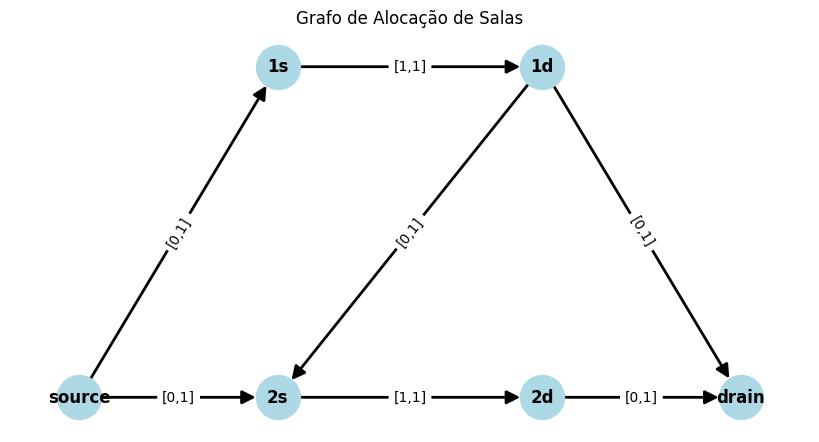

In [81]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np



# -----------------------------------------------
# Construção do grafo
# -----------------------------------------------
G = nx.DiGraph()

# Adiciona nós fonte e dreno
G.add_node('source')
G.add_node('drain')

# Cria nós e arcos principais
for idx, row in df.iterrows():
    i = int(row['reuniao'])
    G.add_node(f'{i}s')
    # G.add_node(f'{i}0')
    G.add_node(f'{i}d')

    G.add_edge('source', f'{i}s',  upperBound=1, lowerBound=0)
    # G.add_edge(f'{i}s', f'{i}0',  upperBound=1, lowerBound=1)
    # G.add_edge(f'{i}0', f'{i}d',  upperBound=1, lowerBound=1)
    G.add_edge(f'{i}s', f'{i}d',  upperBound=1, lowerBound=1)
    G.add_edge(f'{i}d', 'drain',  upperBound=1, lowerBound=0)

# Arcos de não sobreposição
for idx_i, row_i in df.iterrows():
    i = int(row_i["reuniao"])
    termino_i = row_i["termino"]

    for idx_j, row_j in df.iterrows():
        j = int(row_j["reuniao"])
        inicio_j = row_j["inicio"]

        if termino_i <= inicio_j:
            G.add_edge(f'{i}d', f'{j}s', upperBound=1, lowerBound=0)

# -----------------------------------------------
# Definindo as posições organizadas dos nós
# -----------------------------------------------

pos = {}

# Nó fonte na esquerda
pos['source'] = (-1.5, len(df) / 2)

# Nó dreno na direita
pos['drain'] = (3.5, len(df) / 2)

# Parâmetro de desalinhamento horizontal dos nós centrais
shift_amplitude = 0.3

# Para cada reunião, posiciona os três nós em colunas
for idx, row in df.iterrows():
    i = int(row['reuniao'])
    y = len(df) - idx  # Para organizar de cima para baixo

    pos[f'{i}s'] = (0, y)
    # pos[f'{i}0'] = (1.75, y)  # Meio do grafo
    pos[f'{i}d'] = (2, y)

# -----------------------------------------------
# Plotando o grafo
# -----------------------------------------------
plt.figure(figsize=(8, 4))
nx.draw(
    G, pos,
    with_labels=True, node_size=1000,
    node_color="lightblue",
    arrowsize=20, width=2, font_size=12, font_weight='bold'
)

# Desenhar rótulos das capacidades
edge_labels = {(u, v): f"[{d['lowerBound']},{d['upperBound']}]" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Grafo de Alocação de Salas")
plt.axis('off')
plt.show()


In [74]:
print(SolveMinFlow(G, True))

Max flow solution on original graph:
Solution:
 {'f': np.float64(2.0), 'flow_source_1s': np.float64(1.0), 'flow_source_2s': np.float64(1.0), 'flow_1s_1d': np.float64(1.0), 'flow_1d_drain': np.float64(1.0), 'flow_1d_2s': np.float64(0.0), 'flow_2s_2d': np.float64(1.0), 'flow_2d_drain': np.float64(1.0)}
Optimum value:
 2.0

Max flow solution on transformed graph:
Solution:
 {'f': np.float64(0.0), 'flow_drain_1d': np.float64(0.0), 'flow_drain_2d': np.float64(0.0), 'flow_1s_source': np.float64(0.0), 'flow_1d_1s': np.float64(0.0), 'flow_2s_source': np.float64(0.0), 'flow_2s_1d': np.float64(0.0), 'flow_2d_2s': np.float64(0.0)}
Optimum value:
 0.0

[2. 1. 1. 1. 1. 0. 1. 1.]
